In [1]:
from setup import *
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection
from itertools import combinations
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage
import random
from matplotlib.ticker import MultipleLocator, MaxNLocator

##  Introduction <a id='section1'></a>

Here we will explore a somatic mutation data set from ["this papaer"](https://www.nature.com/articles/s41586-020-1943-3)(no need to spend too much time on reading this).

Here is the [paper](https://www.sciencedirect.com/science/article/pii/S2211124712004330) you may need to read more carefully , especially for next set of tasks.

### Load mutational catalogs from cancer whole genome sequenced data

Here we will use single base substitution (SBS) data of 2780 cancer genomes from PCAWG project in this assignment. First, let's load the data matrix from the local data folder.

In [2]:
somaticMutations = pd.read_csv ("./data/MutSigCancer/WGS_PCAWG.96.csv")
somaticMutations = somaticMutations.set_index (somaticMutations['Mutation type'] + "_" + somaticMutations['Trinucleotide'])

In [3]:
somaticMutations.head(2)

,Mutation type,Trinucleotide,Biliary-AdenoCA::SP117655,Biliary-AdenoCA::SP117556,Biliary-AdenoCA::SP117627,Biliary-AdenoCA::SP117775,Biliary-AdenoCA::SP117332,Biliary-AdenoCA::SP117712,Biliary-AdenoCA::SP117017,Biliary-AdenoCA::SP117031,...,Uterus-AdenoCA::SP94540,Uterus-AdenoCA::SP95222,Uterus-AdenoCA::SP89389,Uterus-AdenoCA::SP90503,Uterus-AdenoCA::SP92460,Uterus-AdenoCA::SP92931,Uterus-AdenoCA::SP91265,Uterus-AdenoCA::SP89909,Uterus-AdenoCA::SP90629,Uterus-AdenoCA::SP95550
C>A_ACA,C>A,ACA,269,114,105,217,52,192,54,196,...,117,233,94,114,257,139,404,97,250,170
C>A_ACC,C>A,ACC,148,56,71,123,36,139,54,102,...,90,167,59,64,268,75,255,78,188,137


Next we will use the above given function to visualize the data from an individual case:

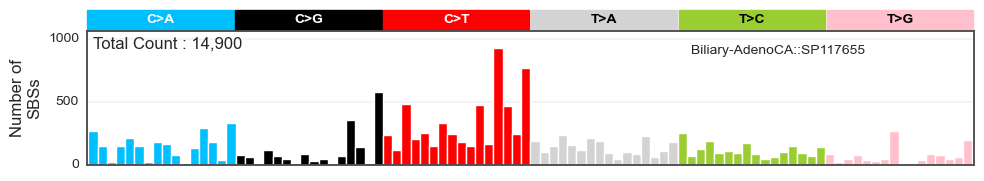

In [4]:
s = 'Biliary-AdenoCA::SP117655'
SBS96_plot(somaticMutations[s], name = s)

### Load mutational signatures from Alexandrov's paper

There are 65 SBS signatures have been reported based on the paper.

In [4]:
SBS_sig = pd.read_csv("./data/MutSigCancer/SBS_signatures.csv")
SBS_sig = SBS_sig.set_index (SBS_sig['Type'] + "_" + SBS_sig['SubType'])
SBS_sig.head(2)

,Type,SubType,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,...,SBS51,SBS52,SBS53,SBS54,SBS55,SBS56,SBS57,SBS58,SBS59,SBS60
C>A_ACA,C>A,ACA,0.000886,5.800000e-07,0.0208,0.0422,0.01200,0.000425,0.000067,0.002330,...,0.14100,0.01520,0.00538,0.002160,0.00588,0.0126,0.01230,0.05890,0.00359,0.006150
C>A_ACC,C>A,ACC,0.002280,1.480000e-04,0.0165,0.0333,0.00944,0.000524,0.000179,0.000461,...,0.00169,0.00654,0.00196,0.000796,0.00205,0.0157,0.00143,0.00675,0.00237,0.000779


Here is an example of showing the spectrum of the fourth signature, which is found associated with tobacco consuming in lung cancers.

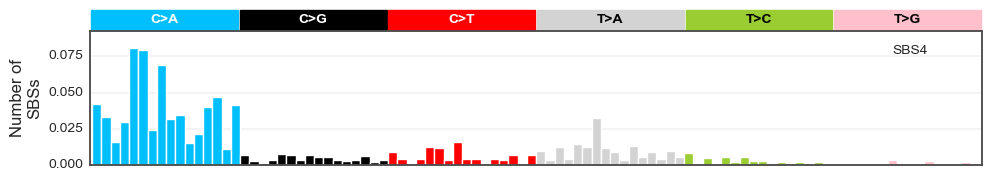

In [6]:
sig_name = 'SBS4'
SBS96_plot(SBS_sig[sig_name], name = sig_name)

In [7]:
channels6 = list(set(list(SBS_sig['Type'].values)))
channels6

['C>G', 'T>G', 'C>T', 'C>A', 'T>A', 'T>C']

### Problem 1: Explore the data in various ways by visualisation as well as summary statistics <a id='Problem1'></a>

#### Problem 1a: 
Using the data matrix somaticMutations make a summary plot of total number of mutations per sample per cancer type, see for reference Figure 1 (the most left panel) in Alexandrov's [paper](https://www.nature.com/articles/s41586-020-1943-3). 

In [9]:
mutationCounts = somaticMutations.drop(columns=['Mutation type', 'Trinucleotide'], axis=1).sum()
summary_df = pd.DataFrame({'Sample': mutationCounts.index, 'Mutations': mutationCounts.values})
summary_df['Cancer_Type'] = summary_df['Sample'].str.split('::', expand=True)[0]
summary_df

,Sample,Mutations,Cancer_Type
0,Biliary-AdenoCA::SP117655,14900,Biliary-AdenoCA
1,Biliary-AdenoCA::SP117556,5088,Biliary-AdenoCA
2,Biliary-AdenoCA::SP117627,5923,Biliary-AdenoCA
3,Biliary-AdenoCA::SP117775,12411,Biliary-AdenoCA
4,Biliary-AdenoCA::SP117332,3456,Biliary-AdenoCA
...,...,...,...
2775,Uterus-AdenoCA::SP92931,4980,Uterus-AdenoCA
2776,Uterus-AdenoCA::SP91265,15617,Uterus-AdenoCA
2777,Uterus-AdenoCA::SP89909,18229,Uterus-AdenoCA
2778,Uterus-AdenoCA::SP90629,34793,Uterus-AdenoCA


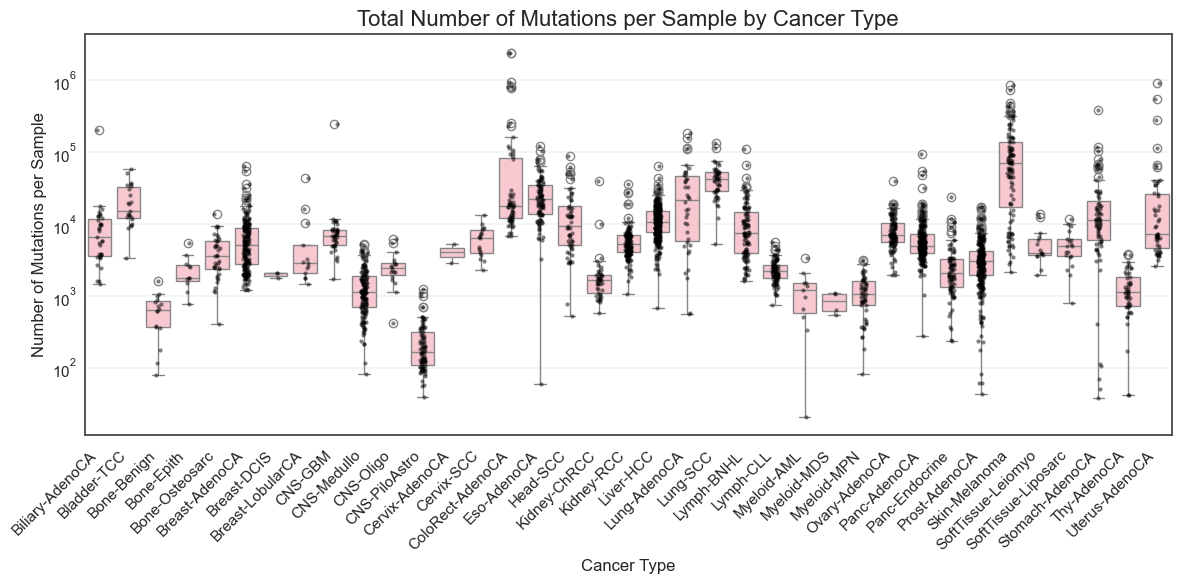

In [15]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cancer_Type', y='Mutations', data=summary_df, color='pink')
sns.stripplot(x='Cancer_Type', y='Mutations', data=summary_df, 
              color='black', size=3, alpha=0.5, jitter=True)

plt.title('Total Number of Mutations per Sample by Cancer Type', fontsize=16)
plt.xlabel('Cancer Type', fontsize=12)
plt.ylabel('Number of Mutations per Sample', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yscale('log') 

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


#### Problem 1b: 
Visualise the mutational signatures. The data is in variable SBS_sig.

I have given one example in the beginning. More references could be found in mutational signature database ["COSMIC: Signatures of Mutational Processes in Human Cancer"](https://cancer.sanger.ac.uk/cosmic/signatures/SBS/).

<b>I have visualised the signature associated with platinum based chemotherapy treatment. This C>T single base substitution signature was also experimentally validated as shown in COSMIC. From the graph, it seems to be more predominant in the C[C>T]C and C[C>T]T context. ["Schiantarelli, J. et. al. (2022)"](https://doi.org/10.1200/PO.22.00183), also coonfirmed the presence of this signature probably due to its presence in TERT, in the same context as above, is earlier shown to be a driver in Thyroid Cancers.</b>

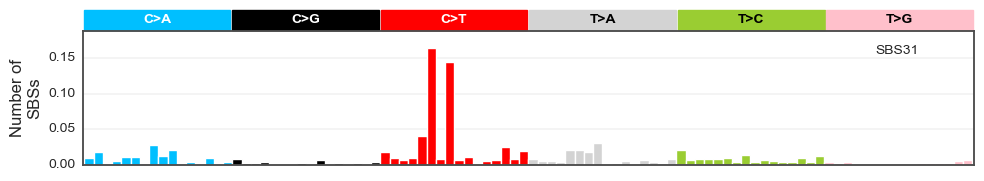

In [16]:
sig_name = 'SBS31'
SBS96_plot(SBS_sig[sig_name], name = sig_name)

#### Problem 1c: 
Normalise 96 mutation channels from individual samples, take the average of normalised 96 channels and visualise the mean proportion per cancer type. First normalise the counts for each sample by the number of muations within that cancer type. Then make an average of these mutation profiles within a cancer type. 

Make this both at the 96 mutation channel level as well as summing over the context so that only 6 mutational channels remain, (as they are listed in channels6).

Can you see differences between cancer types?

<b>While C>T substitutions seem predominant in all cancer types, Skin Melanoma has significantly high number of C>T mutations, especially in the TCC context, compared to other cancers. This seems similar with the SBS7b signature in COSMIC due to exposure to UV light, extracted from cutaneous melanoma and also showed transcriptional strand bias in [Alexandrov et. al. (2020)](https://doi.org/10.1038/s41586-020-1943-3). Also, T>G, followed by T>C, substitutions are significantly dominant in proportion in Esophagael Adeno Carcinomas, contrary to most other cancer types, which is also in line with the findings in [Abbas et. al., (2023)](https://doi.org/10.1038/s41467-023-39957-6) that described C[T>C/G]T as the dominant signautre in EAC. </b>

*Chi square test was performed for overall trend, followed by pairwise chi square tests with FDR.

In [17]:
mutation_data = somaticMutations.set_index(['Mutation type', 'Trinucleotide'])
cancer_types = pd.Series(mutation_data.columns).str.split('::', expand=True)[0]
total_mutations = mutation_data.sum()
normalized_data = mutation_data.div(total_mutations)
cancer_type_dict = dict(zip(normalized_data.columns, cancer_types))
cancer_type_averages = normalized_data.groupby(cancer_type_dict, axis=1).mean()
channels6_data = normalized_data.groupby('Mutation type').sum()
channels6_averages = channels6_data.groupby(cancer_type_dict, axis=1).mean()

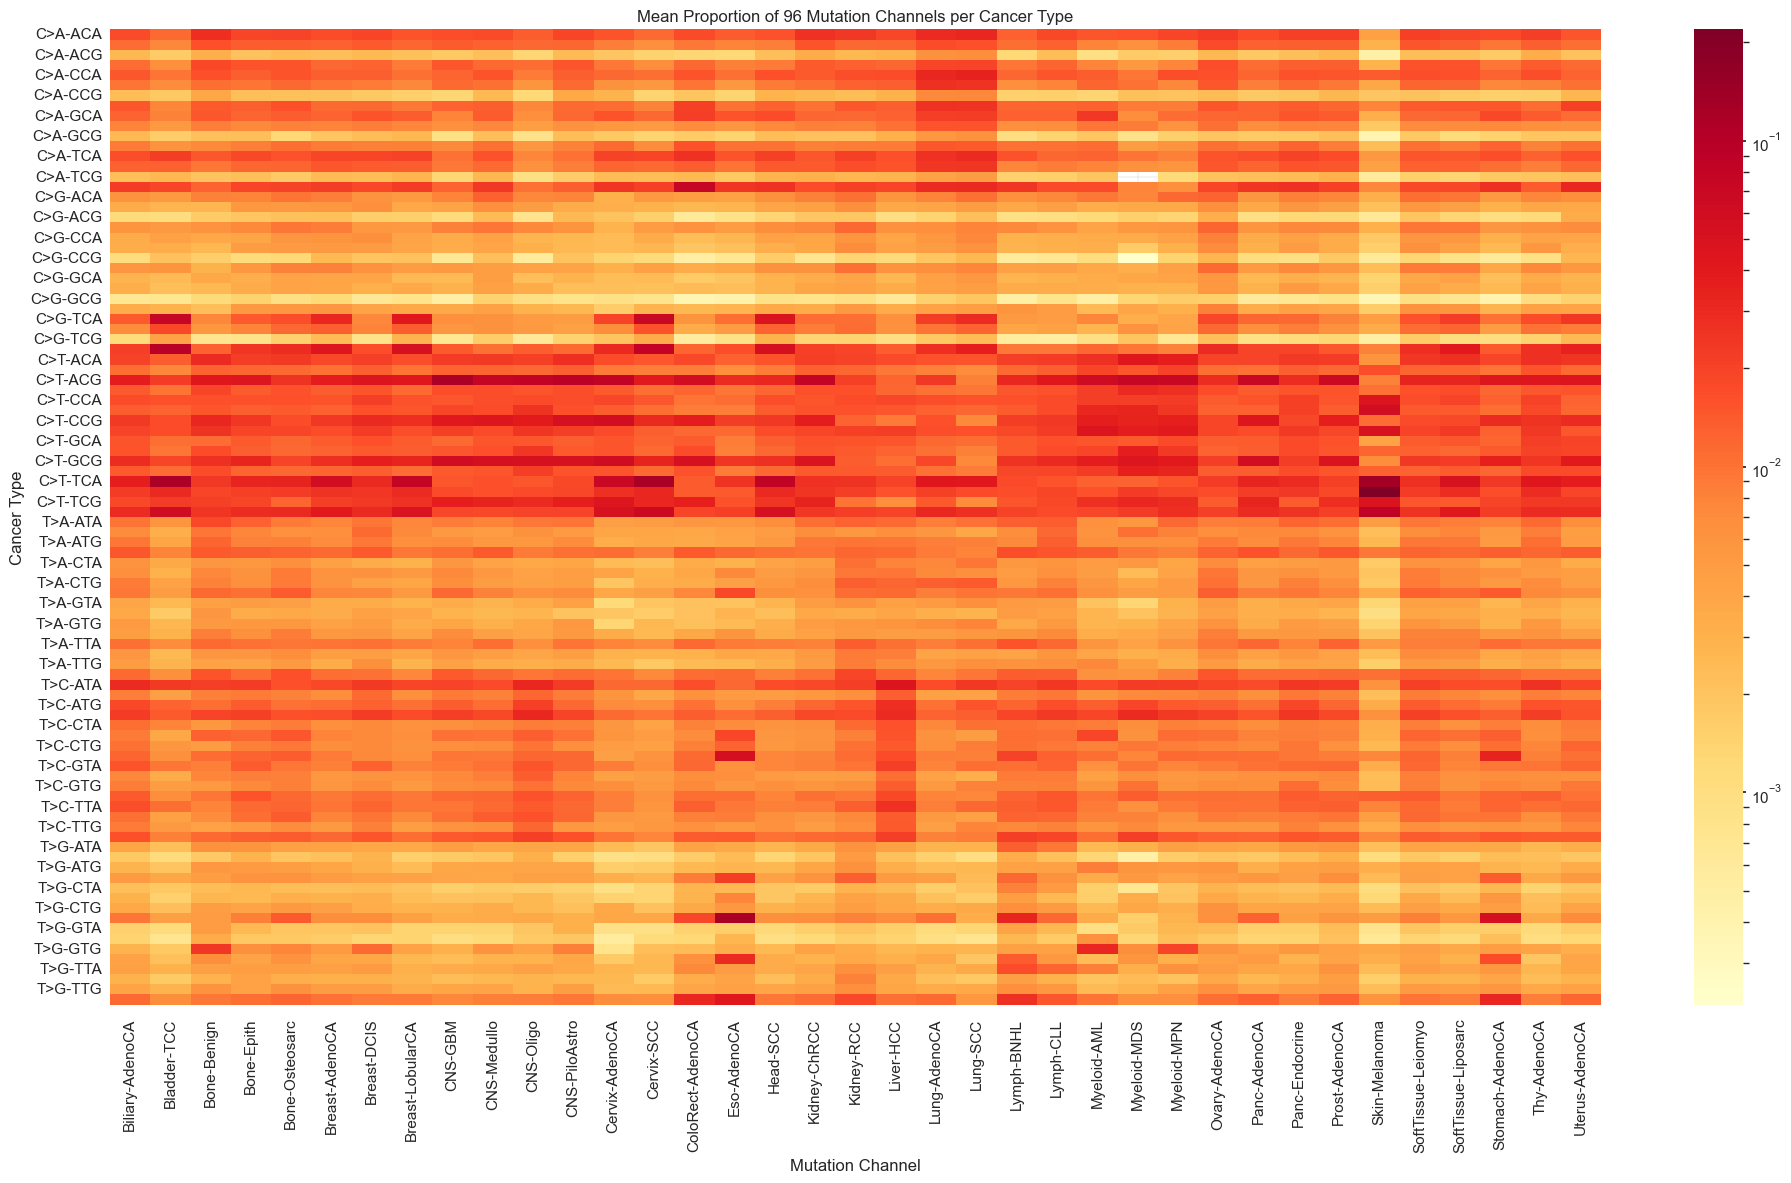

In [18]:
plt.figure(figsize=(20, 12))
sns.heatmap(cancer_type_averages, cmap='YlOrRd', norm=LogNorm())
plt.title('Mean Proportion of 96 Mutation Channels per Cancer Type')
plt.xlabel('Mutation Channel')
plt.ylabel('Cancer Type')
plt.tight_layout()
plt.show()


<Figure size 2400x1600 with 0 Axes>

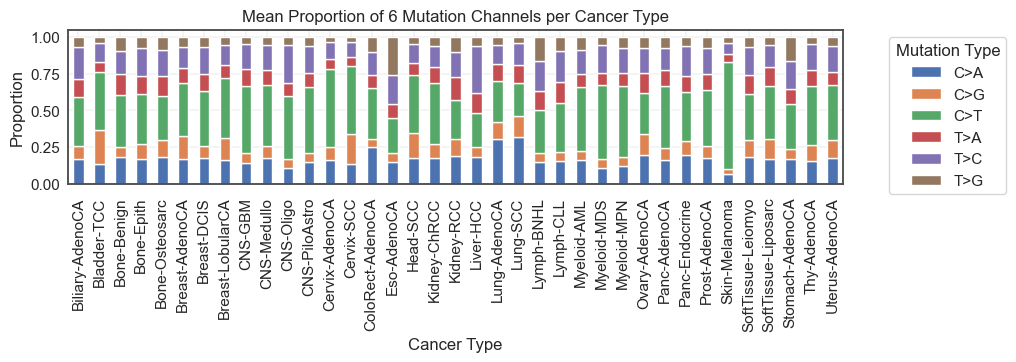

In [19]:
plt.figure(figsize=(24, 16))
channels6_averages.T.plot(kind='bar', stacked=True)
plt.title('Mean Proportion of 6 Mutation Channels per Cancer Type')
plt.xlabel('Cancer Type')
plt.ylabel('Proportion')
plt.legend(title='Mutation Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [21]:
cancer_props = pd.DataFrame(channels6_averages.iloc[5]).reset_index(drop=False).rename({'index':'CancerType','T>G':'T>G_Proportions'}, axis=1)

In [24]:
sample_sizes = pd.DataFrame(pd.Series(cancer_types).value_counts()).reset_index(drop=False).rename({0: 'CancerType','count':'SampleSize'}, axis=1)
data_for_chi = sample_sizes.merge(cancer_props, how='inner', on='CancerType')
data_for_chi['Observed'] = (data_for_chi['T>G_Proportions'] * data_for_chi['SampleSize']).round().astype(int)
data_for_chi['Not_Observed'] = data_for_chi['SampleSize'] - data_for_chi['Observed']

# Create the contingency table
contingency_table = data_for_chi[['Observed', 'Not_Observed']].values

# Perform Chi-square test
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

In [27]:


def pairwise_chi_square_fdr(data_for_chi):
    categories = data_for_chi['CancerType'].tolist()
    p_values = []
    comparisons = []
    
    # Perform pairwise chi-square tests
    for cat in categories:
        group1 = data_for_chi[data_for_chi['CancerType'] == 'Eso-AdenoCA'][['Observed', 'Not_Observed']].values[0]
        group2 = data_for_chi[data_for_chi['CancerType'] == cat][['Observed', 'Not_Observed']].values[0]
        contingency_table = np.array([group1, group2])
        _, p_value, _, _ = stats.chi2_contingency(contingency_table)
        p_values.append(p_value)
        comparisons.append(('Eso-AdenoCA', cat))
    
    # Apply FDR correction
    _, p_corrected = fdrcorrection(p_values)
    
    # Create results dataframe
    results = pd.DataFrame({
        'Comparison': comparisons,
        'P-value': p_values,
        'FDR-corrected P-value': p_corrected
    })
    
    return results

results = pairwise_chi_square_fdr(data_for_chi)

#### Problem 1d: 
Study now the signatures given. How different are they? Make a visualisation of all pairwise distances between the individual signatures. Use cosine distance and Euclidian distance as distance metrics, and compare their results. Use for visualisation heatmaps, c.f. Seaborn package, remember to add colour bars with a scale to all heat maps you plot. Make also figures where you plot all pairwise distances in an ordered way from most similar to least similar. Comment on how the change in the using distance/divergence measure affects this plot.

<b>The cosine distances between the signatures, overall, seem much higher compared to euclidean distances, which directly impacts our interpretation of more number of signatures being similar to each other w.r.t euclidean distances as compared to the very few w.r.t cosine. To find the signatures similar/dissimilar to each other, I used heirarchical clustering with each metric and complete linkage to find more compact clusters. Based on each metric, most of the signatures were assigned to different clusters, except for the ones that were found similar in both, like SBS48 and SBS10a, SBS18 and SBS36, etc. This probably suggests that the combined result of both the clustering metrics are able to capture similarity at the 6 channels level, which can also be seen in SBS48 and SBS10a having C>A dominated SBSs. Similarly in SBS18 and SBS36 with both having additional, minor peaks in the C>T channel too, along with major C>A.</b>

In [29]:
df_transposed = SBS_sig.drop(['Type', 'SubType'], axis=1, inplace=False).T
cosine_distances = pdist(df_transposed, metric='cosine')
euclidean_distances = pdist(df_transposed, metric='euclidean')
distance_matrix_cos = squareform(cosine_distances)
distance_matrix_euc = squareform(euclidean_distances)
pairwise_distances_cos = pd.DataFrame(distance_matrix_cos, 
                                  index=SBS_sig.drop(['Type', 'SubType'], axis=1, inplace=False).columns, 
                                  columns=SBS_sig.drop(['Type', 'SubType'], axis=1, inplace=False).columns)
pairwise_distances_euc = pd.DataFrame(distance_matrix_euc, 
                                  index=SBS_sig.drop(['Type', 'SubType'], axis=1, inplace=False).columns, 
                                  columns=SBS_sig.drop(['Type', 'SubType'], axis=1, inplace=False).columns)


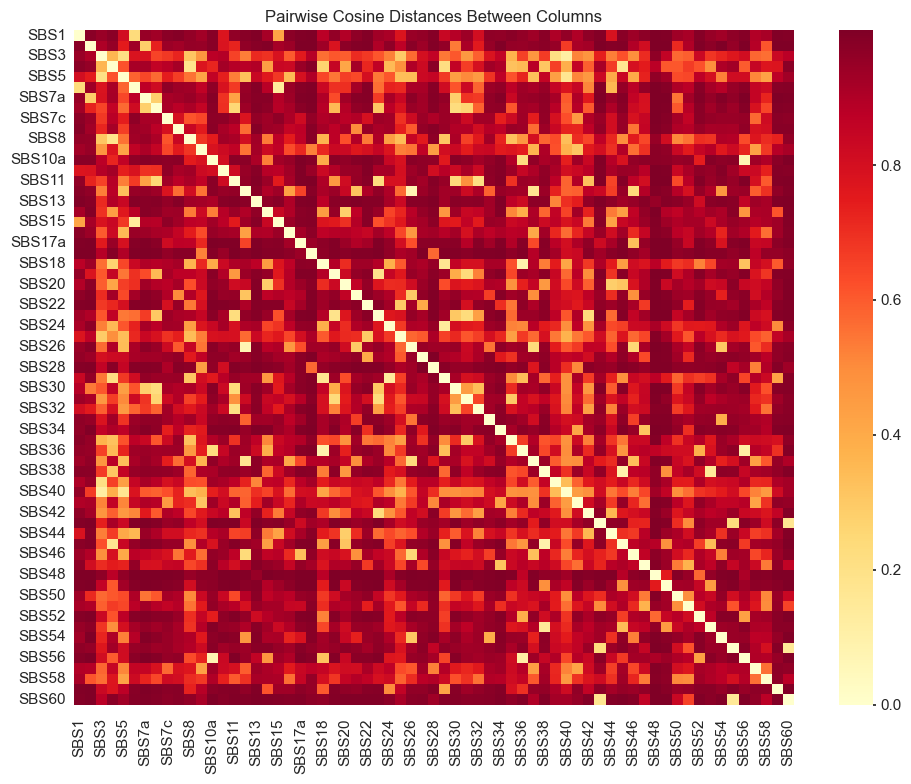

In [30]:
plt.figure(figsize=(10, 8))
sns.heatmap(pairwise_distances_cos, cmap='YlOrRd', annot=False)
plt.title('Pairwise Cosine Distances Between Columns')
plt.tight_layout()
plt.show()

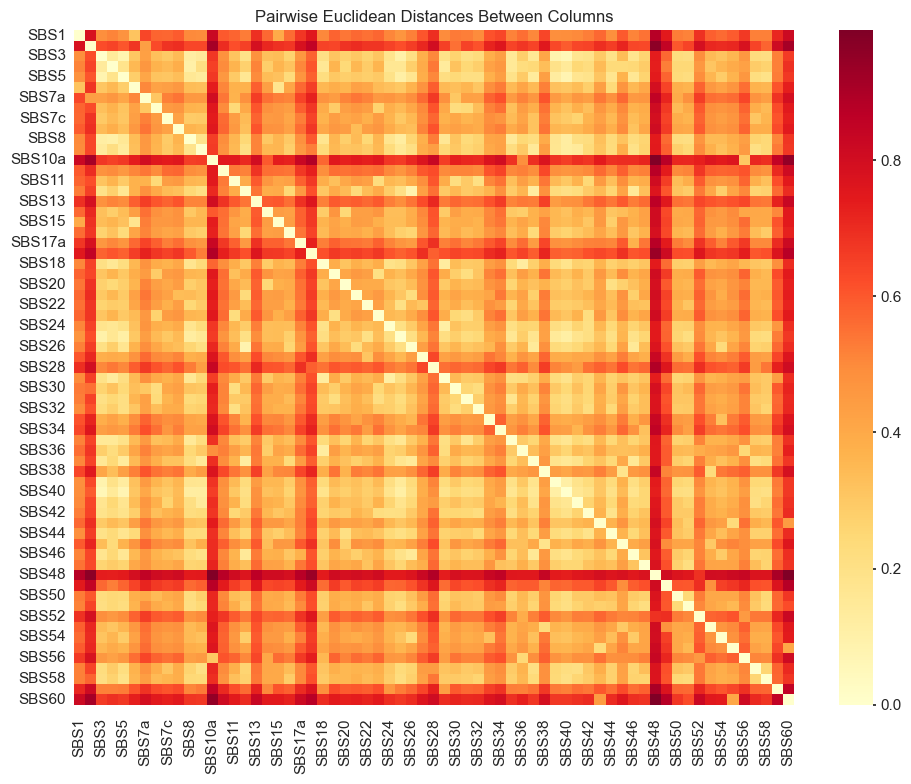

In [31]:
plt.figure(figsize=(10, 8))
sns.heatmap(pairwise_distances_euc, cmap='YlOrRd', annot=False)
plt.title('Pairwise Euclidean Distances Between Columns')
plt.tight_layout()
plt.show()

<Figure size 10000x6000 with 0 Axes>

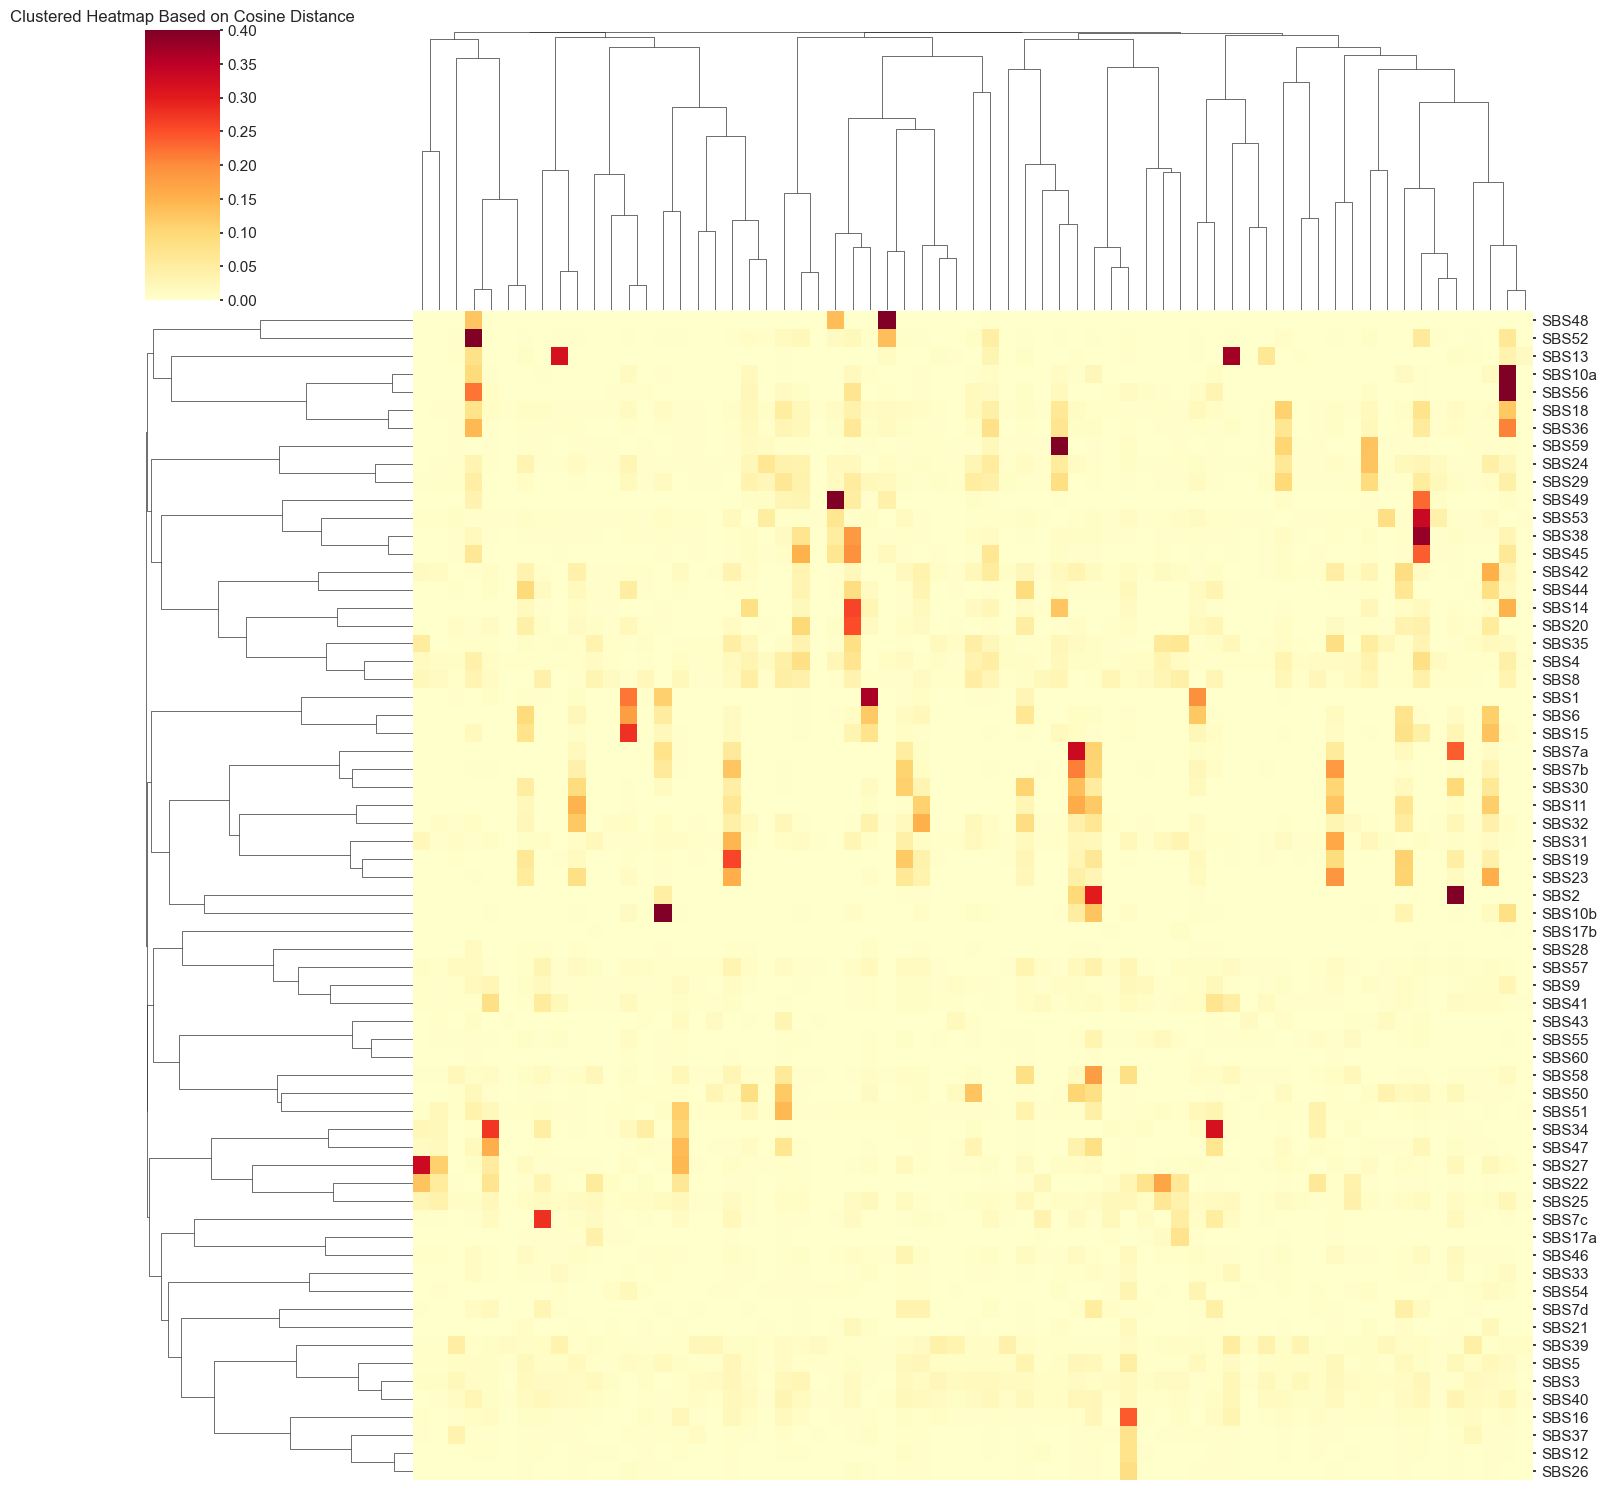

In [47]:
linkage_matrix_cos = linkage(cosine_distances, method='complete')
linkage_matrix_euc = linkage(euclidean_distances, method='complete')
plt.figure(figsize=(100, 60))
sns.clustermap(df_transposed, 
               cmap='YlOrRd', 
               figsize=(15,15),
               standard_scale=None,
               vmin=0.0, vmax=0.4,
               row_linkage=linkage_matrix_cos, 
               col_linkage=linkage_matrix_cos,
               xticklabels=False, 
               yticklabels=True)
plt.title('Clustered Heatmap Based on Cosine Distance')
plt.show()

<Figure size 10000x6000 with 0 Axes>

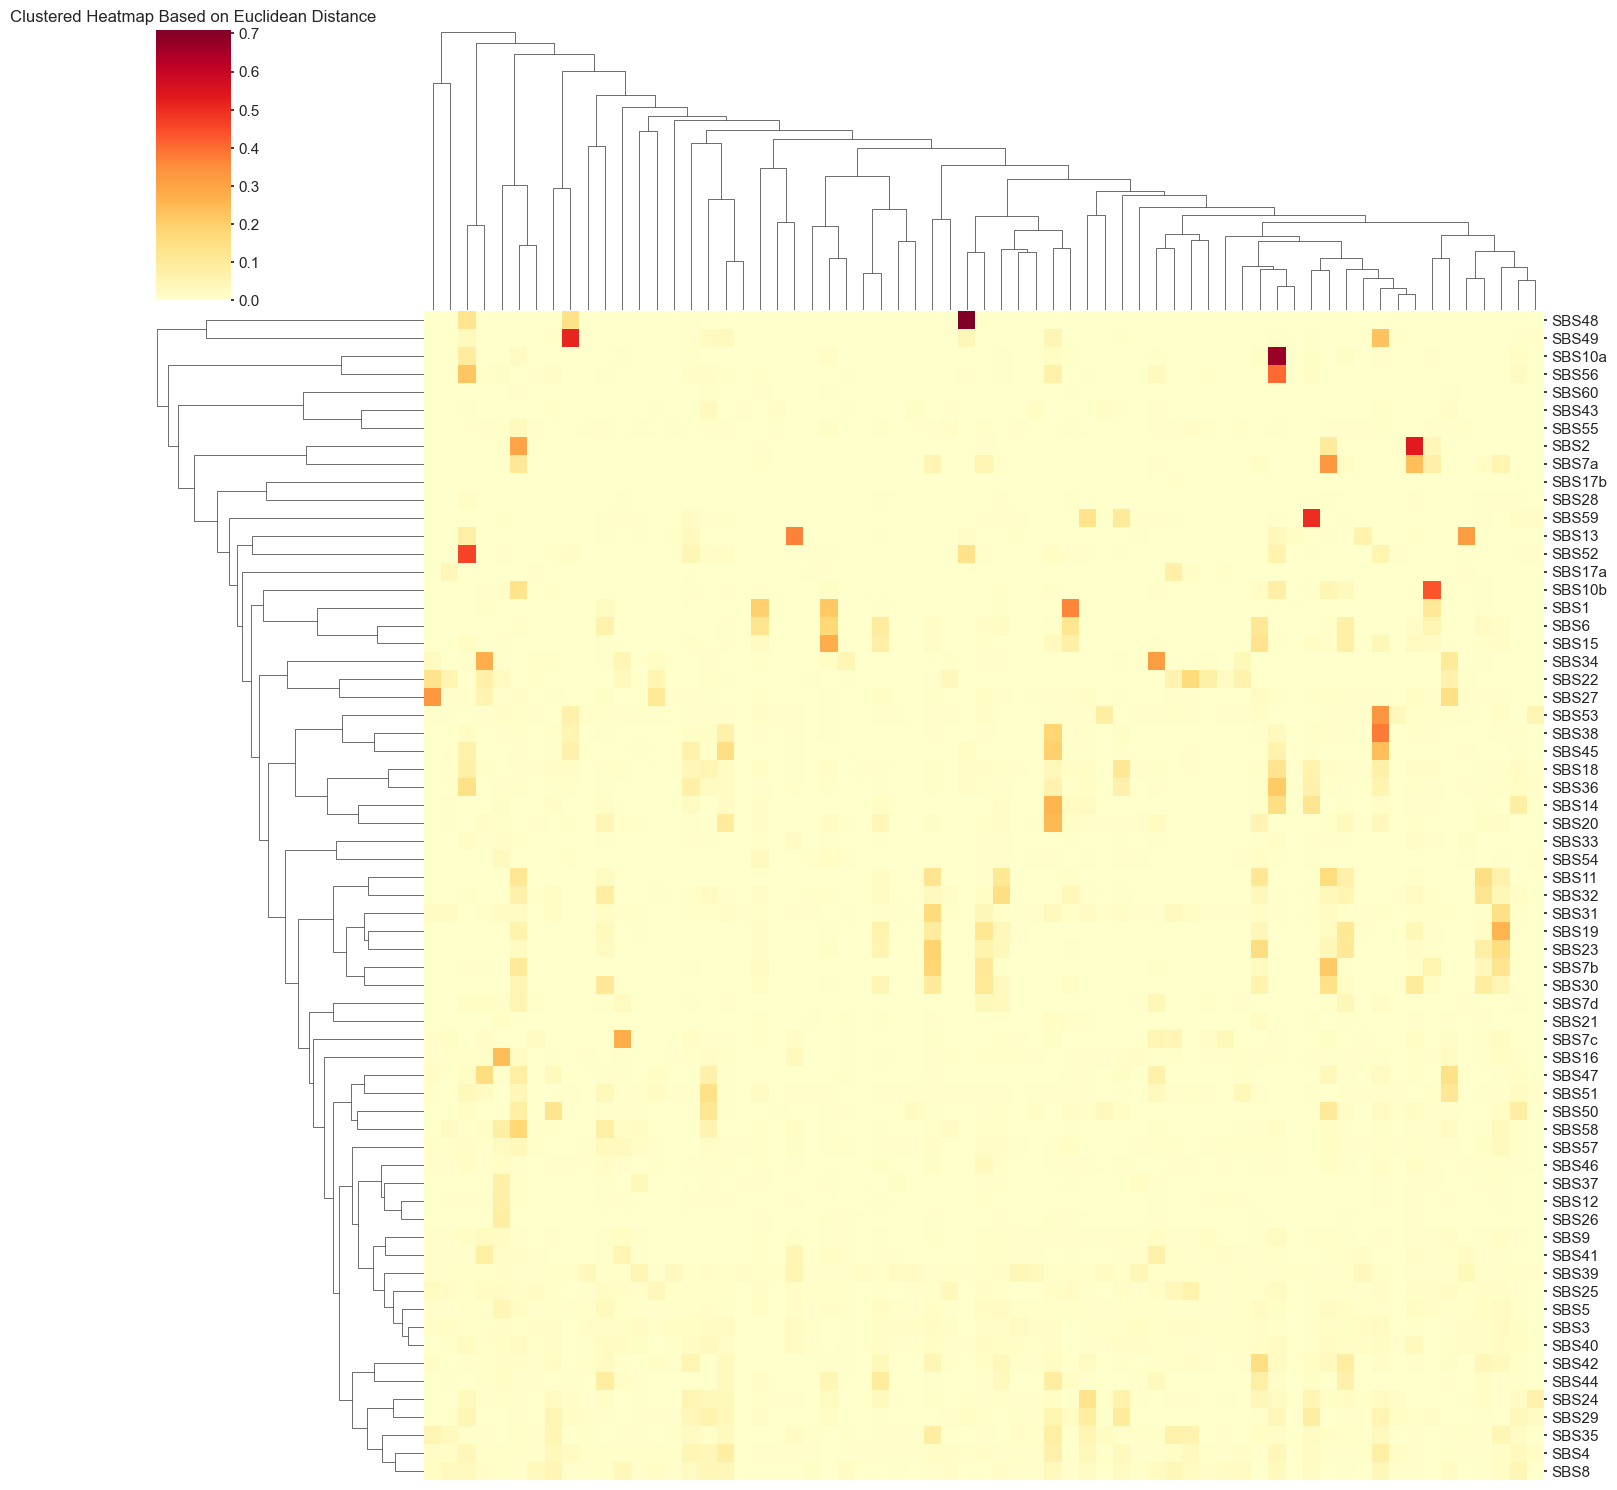

In [48]:
plt.figure(figsize=(100, 60))
sns.clustermap(df_transposed, 
               cmap='YlOrRd', 
               figsize=(15,15),
               standard_scale=None,
               row_linkage=linkage_matrix_euc, 
               col_linkage=linkage_matrix_euc,
               xticklabels=False, 
               yticklabels=True)
plt.title('Clustered Heatmap Based on Euclidean Distance')
plt.show()

### Problem 2: Generate simulated data <a id='Problem1'></a>

#### Problem 2a: 
Use the following instructions with the real signatures to make a function that allows you to simulate data. Make a data set and use it in your analysis below.

To simulate the mutation profile for one sample:
+ Randomly select a number between 3-10 as the active signature number, `n`;
+ Given the active siganture number `n`, randomly pick up `n` signatures from the `SBS_sig` dataset;
+ Generate the total mutation count `M` from a random number between 10000 ~ 30000.
+ Generate the signature exposure vector (to distribute `M` to `n` selected signatures) using the dirichlet distribution;
+ For each selcted mutational signature: get the product of the signature and their exposure and add Poisson noise to the 96-mutational-channel.
+ Add all signature & exposure products together as one simulated mutation profile.

Simulate 1000 samples.

In [21]:
def simulate_mutational_profiles(num, SBS_sig):
    allSimulatedProfiles = np.zeros(shape=(96, 1000))
    allRealProfiles = np.zeros(shape=(96, 1000))
    for prof in range(num):
        n = random.randint(3,10)
        M = random.randint(10000,30001)
        selected_sigs = np.random.choice(SBS_sig.drop(['Type', 'SubType'], axis=1, inplace=False).columns, n, replace=False)
        SBS_sig_selected = SBS_sig[selected_sigs]
        alpha = np.random.uniform(1, 10, n)
        exposure = stats.dirichlet.rvs(alpha, size=1)[0]
        simulated_profile = np.zeros(96)
        real_profile = np.zeros(96)
        
        for i, sig in enumerate(selected_sigs):
            sig_vector = SBS_sig_selected[sig].values
            exp_sig_contribution = M *  sig_vector * exposure[i]
            real_profile += exp_sig_contribution
            simulated_profile += stats.poisson.rvs(exp_sig_contribution)
        
        allSimulatedProfiles[:,prof] = simulated_profile
        allRealProfiles[:,prof] = real_profile
    return allSimulatedProfiles, allRealProfiles
allSimulatedProfiles, allRealProfiles = simulate_mutational_profiles(num=1000, SBS_sig=SBS_sig)
allSimulatedProfiles = pd.DataFrame(allSimulatedProfiles, columns=['Sample'+str(i) for i in range(1,1001)])
allRealProfiles = pd.DataFrame(allRealProfiles, columns=['Sample'+str(i) for i in range(1,1001)])

In [22]:
allRealProfiles.sum(), allSimulatedProfiles.sum()

(Sample1       25167.298241
 Sample2       24879.784104
 Sample3       18493.654610
 Sample4       22629.338984
 Sample5       18984.733776
                   ...     
 Sample996     24723.666052
 Sample997     21064.310294
 Sample998     27041.585175
 Sample999     27090.444929
 Sample1000    23960.626800
 Length: 1000, dtype: float64,
 Sample1       25227.0
 Sample2       25008.0
 Sample3       18447.0
 Sample4       22570.0
 Sample5       18945.0
                ...   
 Sample996     24946.0
 Sample997     20918.0
 Sample998     26994.0
 Sample999     27169.0
 Sample1000    24043.0
 Length: 1000, dtype: float64)

#### Problem 2b:
Make a scatter plot of the real total mutation count vs. simulated mutation counts from the model. Use log scale, comment on what you see?

<b>As 1000 samples were generated from randomly picked n real signatures, I picked random 1000 samples from somaticMutations and plotted their sum several times against the sum of the simulated samples. I can observe that even after sampling multiple times, both in the simulation and from the real mutation counts, the relationship between the two does not follow any trend and seems more scattered across the space, more representative of the randomness of both the processes.</b>

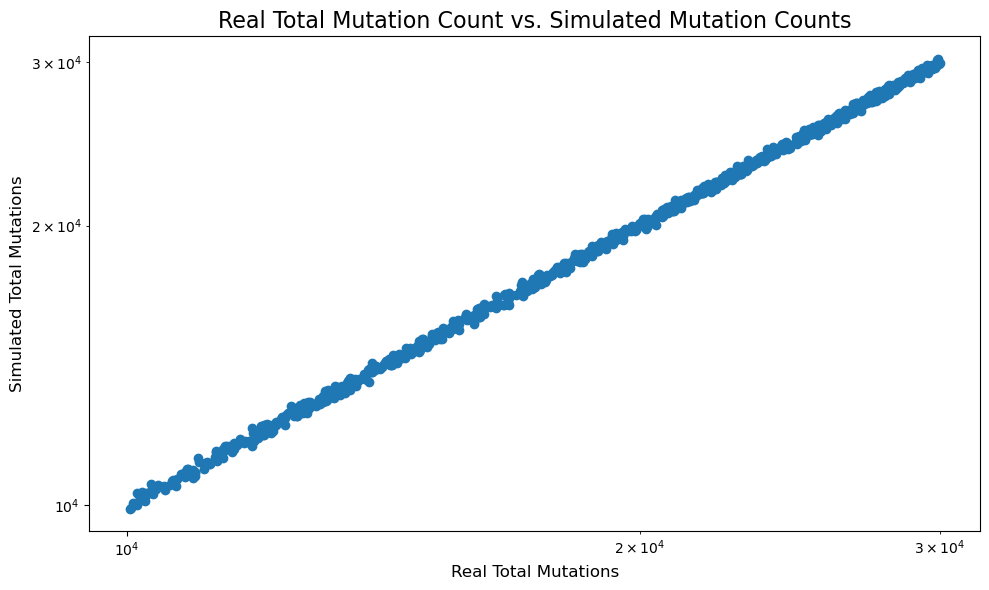

In [24]:
random_real_mutations = np.array(allRealProfiles.sum())
simulated_mutations = np.array(allSimulatedProfiles.sum())

x = random_real_mutations
y = simulated_mutations

plt.figure(figsize=(10, 6))
plt.scatter(x, y) 
plt.xscale('log')
plt.yscale('log')

plt.title('Real Total Mutation Count vs. Simulated Mutation Counts', fontsize=16)
plt.xlabel('Real Total Mutations', fontsize=12)
plt.ylabel('Simulated Total Mutations', fontsize=12)

plt.tight_layout()
plt.show()
